In [78]:
import logging
import pandas as pd
import os
from typing import Any
from algoshort.regime_fc import RegimeFC
from algoshort.returns import ReturnsCalculator
from algoshort.stop_loss import StopLossCalculator   # your stop-loss module
# from algoshort.position_sizing import PositionSizing  # your position sizing module
from algoshort.utils import load_config
from algoshort.optimizer import get_equity, StrategyOptimizer
import numpy as np
from algoshort.yfinance_handler import YFinanceDataHandler
from algoshort.ohlcprocessor import OHLCProcessor
from datetime import date
from algoshort.wrappers import generate_signals

handler = YFinanceDataHandler(cache_dir="./cache", enable_logging=False)
handler.download_data(['MONC.MI', 'FTSEMIB.MI'], start='2016-01-01', end=date.today(), use_cache=True)
df = handler.get_ohlc_data('MONC.MI')
df['fx'] = 1
df.set_index('date')
bmk = handler.get_ohlc_data('FTSEMIB.MI')
df.columns.name = None
bmk.columns.name = None
bmk.set_index('date')

2026-02-03 22:58:15,518 - INFO - Cache hits: 2, Downloads needed: 0
2026-02-03 22:58:15,518 - INFO - Successfully processed 2/2 symbols


,open,high,low,close
date,,,,
2016-01-04,21186.0,21194.0,20702.0,20734.0
2016-01-05,20938.0,20983.0,20722.0,20983.0
2016-01-06,20922.0,20931.0,20373.0,20422.0
2016-01-07,19778.0,20289.0,19629.0,20189.0
2016-01-08,20189.0,20350.0,19869.0,19869.0
...,...,...,...,...
2026-01-27,45147.0,45524.0,44990.0,45440.0
2026-01-28,45452.0,45473.0,44904.0,45139.0
2026-01-29,45375.0,45578.0,44985.0,45076.0


In [79]:
handler.list_available_data()

{'MONC.MI': {'rows': 2548,
  'columns': ['open', 'high', 'low', 'close', 'volume'],
  'date_range': '2016-01-04 to 2026-01-13',
  'missing_values': np.int64(0)},
 'FTSEMIB.MI': {'rows': 2561,
  'columns': ['open', 'high', 'low', 'close', 'volume'],
  'date_range': '2016-01-04 to 2026-02-02',
  'missing_values': np.int64(0)}}

In [80]:
from algoshort.ohlcprocessor import OHLCProcessor
processor = OHLCProcessor()
df = processor.calculate_relative_prices(
    stock_data= df,
    benchmark_data= bmk
    )

2026-02-03 22:58:15,615 - INFO - Merging primary data (shape: (2548, 6)) with benchmark data (shape: (2561, 5)).
2026-02-03 22:58:15,615 - INFO - Merge completed. New DataFrame shape: (2548, 7)
2026-02-03 22:58:15,615 - INFO - Rebasing benchmark to 1.0 using the first value: 20734.0
2026-02-03 22:58:15,615 - INFO - Calculating relative OHLC prices...
2026-02-03 22:58:15,627 - INFO - Relative price calculation complete.


In [81]:
tt_search_space = {
    'fast': [20, 30],
    'slow': [50, 70]
}

bo_search_space = [50, 100, 150]

ma_search_space = {
    'short_ma': [50, 70],
    'medium_ma': [100, 150],
    'long_ma': [150, 200]
}


df, signal_columns = generate_signals(
    df=df,
    tt_search_space=tt_search_space,
    bo_search_space=bo_search_space,
    ma_search_space=ma_search_space,
)
df.columns

2026-02-03 22:58:15,684 - algoshort.regime_fc.RegimeFC - INFO - Initialized Regime_fc with DataFrame of shape (2548, 54)
2026-02-03 22:58:15,684 - INFO - Initialized Regime_fc with DataFrame of shape (2548, 54)
2026-02-03 22:58:15,684 - algoshort.regime_fc.RegimeFC - INFO - Starting regime analysis (relative=True)
2026-02-03 22:58:15,684 - INFO - Starting regime analysis (relative=True)
2026-02-03 22:58:15,684 - algoshort.regime_fc.RegimeFC - INFO - Starting swings analysis (relative=True)
2026-02-03 22:58:15,684 - INFO - Starting swings analysis (relative=True)
2026-02-03 22:58:15,684 - algoshort.regime_fc.RegimeFC - INFO - Starting historical_swings analysis (relative=True)
2026-02-03 22:58:15,684 - INFO - Starting historical_swings analysis (relative=True)
2026-02-03 22:58:15,714 - algoshort.regime_fc.RegimeFC - INFO - historical_swings completed with 4 swing levels
2026-02-03 22:58:15,714 - INFO - historical_swings completed with 4 swing levels
2026-02-03 22:58:15,730 - algoshort.r

Index Match -> Window: 50
Index Match -> Window: 100
Index Match -> Window: 150
Index Match -> short: 20, long: 50
Index Match -> short: 30, long: 70
Index Match -> short: 50, medium: 100, long: 150
Index Match -> short: 70, medium: 150, long: 200
Index Match -> short: 50, medium: 100, long: 150
Index Match -> short: 70, medium: 150, long: 200


Index(['date', 'open', 'high', 'low', 'close', 'fx', 'ropen', 'rhigh', 'rlow',
       'rclose', 'rhi_50', 'rlo_50', 'rbo_50', 'rhi_100', 'rlo_100', 'rbo_100',
       'rhi_150', 'rlo_150', 'rbo_150', 'rhi_20', 'rlo_20', 'rbo_20',
       'rtt_5020', 'rhi_70', 'rlo_70', 'rhi_30', 'rlo_30', 'rbo_70', 'rbo_30',
       'rtt_7030', 'rsma_short_50', 'rsma_medium_100', 'rsma_50100',
       'rsma_long_150', 'rsma_100150', 'rsma_50100150', 'rsma_short_70',
       'rsma_medium_150', 'rsma_70150', 'rsma_long_200', 'rsma_150200',
       'rsma_70150200', 'rema_short_50', 'rema_medium_100', 'rema_50100',
       'rema_long_150', 'rema_100150', 'rema_50100150', 'rema_short_70',
       'rema_medium_150', 'rema_70150', 'rema_long_200', 'rema_150200',
       'rema_70150200', 'rh1', 'rl1', 'rh2', 'rl2', 'rh3', 'rl3', 'rh4', 'rl4',
       'rrt', 'rrg', 'rflr', 'rclg', 'rrg_ch'],
      dtype='object')

In [82]:
# from algoshort.combiner import HybridSignalCombiner

# combiner = HybridSignalCombiner(
#     verbose=True,
#     direction_col='rrg',
#     entry_col='rbo_100',
#     exit_col='rsma_2050100'
#     )
# df = combiner.combine_signals(df, allow_flips=True, require_regime_alignment=True)
# df

In [83]:
signal_columns = [x for x in signal_columns if x != "rrg"]
signal_columns

['rbo_50',
 'rbo_100',
 'rbo_150',
 'rbo_20',
 'rtt_5020',
 'rbo_70',
 'rbo_30',
 'rtt_7030',
 'rsma_50100',
 'rsma_100150',
 'rsma_50100150',
 'rsma_70150',
 'rsma_150200',
 'rsma_70150200',
 'rema_50100',
 'rema_100150',
 'rema_50100150',
 'rema_70150',
 'rema_150200',
 'rema_70150200']

In [84]:
# signal_columns = ['rema_70150200', 'rsma_150200', 'rsma_100150', 'rsma_2050100']

In [85]:
from algoshort.combiner import SignalGridSearch

# grid_search = SignalGridSearch(
#         df=df,
#         available_signals=signal_columns,
#         direction_col='rrg'  # Fixed direction filter
#     )

# results = grid_search.run_grid_search(
#         allow_flips=True,
#         require_regime_alignment=True,
#         verbose=False
#     )

In [86]:
# Assuming you have a DataFrame and signals
searcher = SignalGridSearch(
    df=df,
    available_signals=signal_columns,
    direction_col='rrg'
)

# Run with default settings (all cores, multiprocessing)
results = searcher.run_grid_search_parallel(
    allow_flips=True,
    require_regime_alignment=True
)

print("\nTop 5 combinations by total trades:")
print(results.nlargest(5, 'total_trades')[
    ['combination_name', 'total_trades', 'long_pct', 'short_pct']
])


# # Example 2: Controlled parallelism with joblib
# print("\n" + "="*70)
# print("EXAMPLE 2: Joblib Backend with Custom Settings")
# print("="*70)

# # Run with joblib backend and limited cores
# results = searcher.run_grid_search_parallel(
#     allow_flips=False,
#     require_regime_alignment=True,
#     n_jobs=4,              # Use only 4 cores
#     backend='joblib',      # Better error handling
#     batch_size=10,         # Process 10 combinations per batch
#     verbose=False
# )

# # Filter successful combinations
# successful = results[results['success'] == True]
# print(f"\nSuccessful combinations: {len(successful)}/{len(results)}")


# Example 3: Performance comparison
print("\n" + "="*70)
print("EXAMPLE 3: Sequential vs Parallel Performance")
print("="*70)

# import time

# # Sequential
# start = time.time()
# results_seq = searcher.run_grid_search(
#     allow_flips=True,
#     require_regime_alignment=True
# )
# seq_time = time.time() - start

# # Parallel
# start = time.time()
# results_par = searcher.run_grid_search_parallel(
#     allow_flips=True,
#     require_regime_alignment=True,
#     n_jobs=-1
# )
# par_time = time.time() - start

# print(f"\n{'='*70}")
# print("PERFORMANCE COMPARISON")
# print(f"{'='*70}")
# print(f"Sequential time: {seq_time:.2f} seconds")
# print(f"Parallel time:   {par_time:.2f} seconds")
# print(f"Speedup:         {seq_time/par_time:.2f}x")
# print(f"Cores used:      {cpu_count()}")

print("\nExamples complete. Uncomment code blocks to run.")

✓ Validation passed: All 20 signals found in dataframe

GRID GENERATION
Direction column: rrg
Available signals for entry/exit: 20
Signals: ['rbo_50', 'rbo_100', 'rbo_150', 'rbo_20', 'rtt_5020', 'rbo_70', 'rbo_30', 'rtt_7030', 'rsma_50100', 'rsma_100150', 'rsma_50100150', 'rsma_70150', 'rsma_150200', 'rsma_70150200', 'rema_50100', 'rema_100150', 'rema_50100150', 'rema_70150', 'rema_150200', 'rema_70150200']

Total combinations to test: 400
  = 20 entry signals × 20 exit signals

RUNNING PARALLEL GRID SEARCH
Direction column: rrg
Allow flips: True
Require regime alignment: True
Backend: multiprocessing
Parallel jobs: 22 cores

Processing 400 combinations in parallel...


Testing combinations: 100%|██████████| 400/400 [00:13<00:00, 30.29it/s]



Adding combined signal columns to main dataframe...

GRID SEARCH COMPLETE
Successful combinations: 400
Failed combinations: 0

Top 5 combinations by total trades:
                     combination_name  total_trades   long_pct  short_pct
383  entry_rema_70150200__exit_rbo_20           417  48.273155   2.315542
323  entry_rema_50100150__exit_rbo_20           416  48.390895   3.414443
363    entry_rema_150200__exit_rbo_20           402  43.288854   2.904239
303    entry_rema_100150__exit_rbo_20           384  43.799058   3.178964
243    entry_rsma_150200__exit_rbo_20           376  39.050235   3.100471

EXAMPLE 3: Sequential vs Parallel Performance

Examples complete. Uncomment code blocks to run.


In [87]:
results

,combination_name,entry_signal,exit_signal,direction_signal,output_column,total_trades,long_trades,short_trades,long_to_short_flips,short_to_long_flips,long_bars,short_bars,flat_bars,long_pct,short_pct,flat_pct,avg_bars_per_long_trade,avg_bars_per_short_trade,success,error
0,entry_rbo_50__exit_rbo_50,rbo_50,rbo_50,rrg,entry_rbo_50__exit_rbo_50,18,15,3,0,0,1126,49,1373,44.191523,1.923077,53.885400,75.066667,16.333333,True,None
1,entry_rbo_50__exit_rbo_100,rbo_50,rbo_100,rrg,entry_rbo_50__exit_rbo_100,71,65,6,0,0,1441,45,1062,56.554160,1.766091,41.679749,22.169231,7.500000,True,None
2,entry_rbo_50__exit_rbo_150,rbo_50,rbo_150,rrg,entry_rbo_50__exit_rbo_150,114,105,8,1,0,1457,43,1048,57.182104,1.687598,41.130298,13.876190,5.375000,True,None
3,entry_rbo_50__exit_rbo_20,rbo_50,rbo_20,rrg,entry_rbo_50__exit_rbo_20,182,176,6,0,0,943,46,1559,37.009419,1.805338,61.185243,5.357955,7.666667,True,None
4,entry_rbo_50__exit_rtt_5020,rbo_50,rtt_5020,rrg,entry_rbo_50__exit_rtt_5020,18,15,3,0,0,1126,49,1373,44.191523,1.923077,53.885400,75.066667,16.333333,True,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,entry_rema_70150200__exit_rema_100150,rema_70150200,rema_100150,rrg,entry_rema_70150200__exit_rema_100150,148,134,13,0,1,1521,71,956,59.693878,2.786499,37.519623,11.350746,5.461538,True,None
396,entry_rema_70150200__exit_rema_50100150,rema_70150200,rema_50100150,rrg,entry_rema_70150200__exit_rema_50100150,109,89,20,0,0,1510,56,982,59.262166,2.197802,38.540031,16.966292,2.800000,True,None
397,entry_rema_70150200__exit_rema_70150,rema_70150200,rema_70150,rrg,entry_rema_70150200__exit_rema_70150,160,132,27,0,1,1481,57,1010,58.124019,2.237049,39.638932,11.219697,2.111111,True,None
398,entry_rema_70150200__exit_rema_150200,rema_70150200,rema_150200,rrg,entry_rema_70150200__exit_rema_150200,144,130,13,1,0,1594,63,891,62.558870,2.472527,34.968603,12.261538,4.846154,True,None


In [88]:
# results.total_trades
# results.short_trades
# results.long_trades

In [89]:
# results.combination_name
# results.entry_signal
# results.exit_signal
# results.output_column
# results['output_column']
searcher.df

,date,open,high,low,close,fx,ropen,rhigh,rlow,rclose,...,entry_rema_70150200__exit_rsma_50100150,entry_rema_70150200__exit_rsma_70150,entry_rema_70150200__exit_rsma_150200,entry_rema_70150200__exit_rsma_70150200,entry_rema_70150200__exit_rema_50100,entry_rema_70150200__exit_rema_100150,entry_rema_70150200__exit_rema_50100150,entry_rema_70150200__exit_rema_70150,entry_rema_70150200__exit_rema_150200,entry_rema_70150200__exit_rema_70150200
0,2016-01-04,11.405756,11.405756,10.836358,11.076572,1,11.4058,11.4058,10.8364,11.0766,...,0,0,0,0,0,0,0,0,0,0
1,2016-01-05,11.210025,11.245612,10.809666,10.969810,1,11.0770,11.1122,10.6814,10.8396,...,0,0,0,0,0,0,0,0,0,0
2,2016-01-06,10.987605,11.014295,10.720700,10.845255,1,11.1555,11.1826,10.8845,11.0109,...,0,0,0,0,0,0,0,0,0,0
3,2016-01-07,10.569453,11.076573,10.053436,10.898636,1,10.8548,11.3756,10.3248,11.1928,...,0,0,0,0,0,0,0,0,0,0
4,2016-01-08,10.952017,11.094366,10.774079,10.987604,1,11.4288,11.5774,11.2431,11.4660,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2543,2026-01-07,54.500000,54.520000,51.919998,53.000000,1,24.8031,24.8122,23.6289,24.1204,...,0,0,0,0,0,0,0,0,0,0
2544,2026-01-08,52.700001,53.220001,52.419998,53.080002,1,23.9245,24.1606,23.7974,24.0971,...,0,0,0,0,0,0,0,0,0,0
2545,2026-01-09,52.779999,54.279999,52.439999,54.119999,1,23.9362,24.6165,23.7820,24.5439,...,0,0,0,0,0,0,0,0,0,0
2546,2026-01-12,54.419998,54.419998,52.860001,53.599998,1,24.6730,24.6730,23.9657,24.3012,...,0,0,0,0,0,0,0,0,0,0


In [90]:
# output_cols = grid_search.get_signal_columns()
output_cols = results.combination_name
from algoshort.wrappers import calculate_return
# df = grid_search.df
df = searcher.df
df = calculate_return(stock_data=df, signal_columns=output_cols, relative=True)


In [91]:
# df.columns

In [92]:


# identify cumul columns
cumul_cols = [c for c in df.columns if c.endswith("cumul")]
df_last = df.tail(1)
# pivot longer
df_long = (
    df_last.melt(
        id_vars="date",
        value_vars=cumul_cols,
        var_name="metric",
        value_name="value"
    )
)

df_long = ( df_long .sort_values("value", ascending=False) .reset_index(drop=True) )

df_long

,date,metric,value
0,2026-01-13,entry_rema_50100150__exit_rema_50100150_cumul,2.694152
1,2026-01-13,entry_rema_50100150__exit_rtt_5020_cumul,2.625102
2,2026-01-13,entry_rbo_20__exit_rsma_70150200_cumul,2.428332
3,2026-01-13,entry_rsma_50100150__exit_rema_50100150_cumul,2.386233
4,2026-01-13,entry_rbo_20__exit_rtt_5020_cumul,2.379049
...,...,...,...
395,2026-01-13,entry_rsma_70150__exit_rsma_70150200_cumul,0.149762
396,2026-01-13,entry_rtt_7030__exit_rbo_20_cumul,0.147752
397,2026-01-13,entry_rtt_7030__exit_rsma_70150200_cumul,0.144428
398,2026-01-13,entry_rtt_7030__exit_rsma_150200_cumul,0.139358


In [93]:
df_long["combination_name"] = df_long["metric"].str.replace(r"_cumul$", "", regex=True)
df_long = df_long.merge(results[['combination_name', 'total_trades']], on='combination_name').sort_values("value", ascending=False) .reset_index(drop=True)

In [94]:
df_long.head(20)

,date,metric,value,combination_name,total_trades
0,2026-01-13,entry_rema_50100150__exit_rema_50100150_cumul,2.694152,entry_rema_50100150__exit_rema_50100150,19
1,2026-01-13,entry_rema_50100150__exit_rtt_5020_cumul,2.625102,entry_rema_50100150__exit_rtt_5020,254
2,2026-01-13,entry_rbo_20__exit_rsma_70150200_cumul,2.428332,entry_rbo_20__exit_rsma_70150200,150
3,2026-01-13,entry_rsma_50100150__exit_rema_50100150_cumul,2.386233,entry_rsma_50100150__exit_rema_50100150,69
4,2026-01-13,entry_rbo_20__exit_rtt_5020_cumul,2.379049,entry_rbo_20__exit_rtt_5020,25
5,2026-01-13,entry_rema_50100150__exit_rema_100150_cumul,2.342600,entry_rema_50100150__exit_rema_100150,175
6,2026-01-13,entry_rbo_20__exit_rbo_50_cumul,2.271240,entry_rbo_20__exit_rbo_50,127
7,2026-01-13,entry_rsma_50100150__exit_rsma_100150_cumul,2.234821,entry_rsma_50100150__exit_rsma_100150,186
8,2026-01-13,entry_rema_70150200__exit_rbo_50_cumul,2.210925,entry_rema_70150200__exit_rbo_50,345
9,2026-01-13,entry_rema_50100150__exit_rema_150200_cumul,2.208705,entry_rema_50100150__exit_rema_150200,152


In [95]:
# grid_search.df.columns

# grid_search.export_dataframe('all_signal.cvs')

# grid_search.df.to_excel('all_signal.xlsx')
# df.to_excel('all_signal.xlsx')

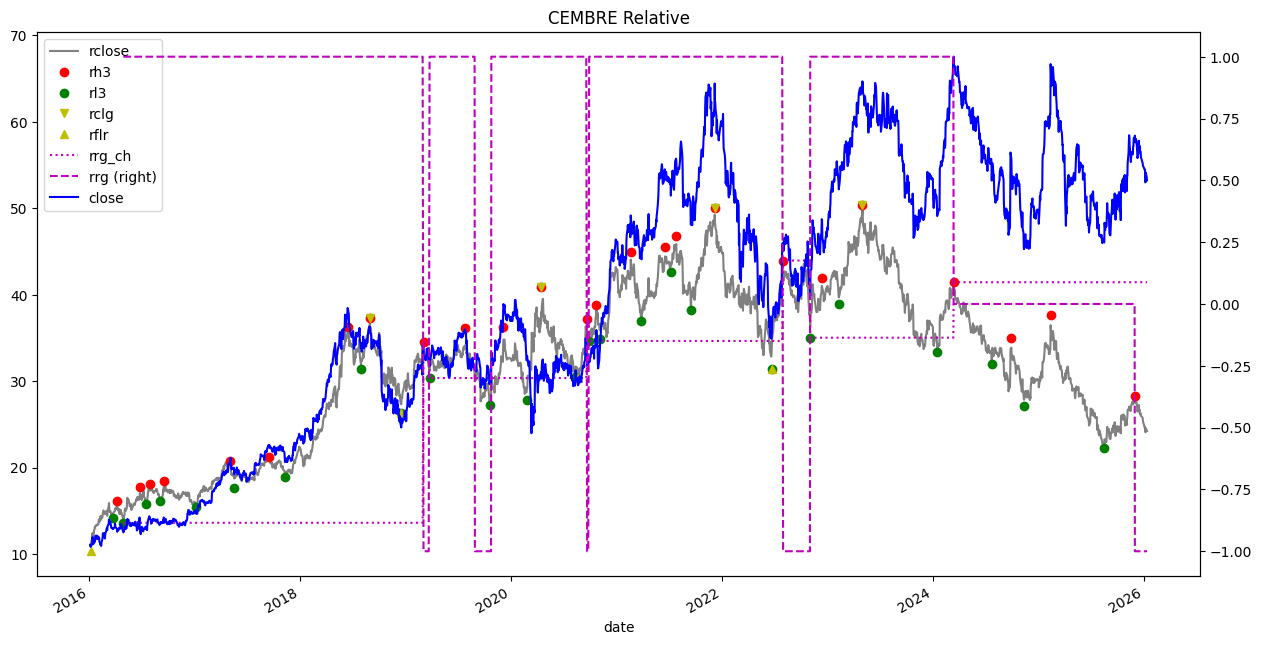

In [96]:
def plot_signal_rel(df, ticker):
    
    plot_rel_cols = ['rclose','rh3','rl3','rclg','rflr','rrg_ch','rrg','close']
    plot_rel_style = ['grey','ro','go','yv','y^','m:','m--','b']  # added style for 'close'
    y2_rel = ['rrg']

    df = df.set_index('date')

    df[plot_rel_cols].plot(
        secondary_y=y2_rel,
        figsize=(15,8),
        title=str.upper(ticker) + ' Relative',
        style=plot_rel_style
    )
    plt.show()

plot_signal_rel(df, 'cembre')

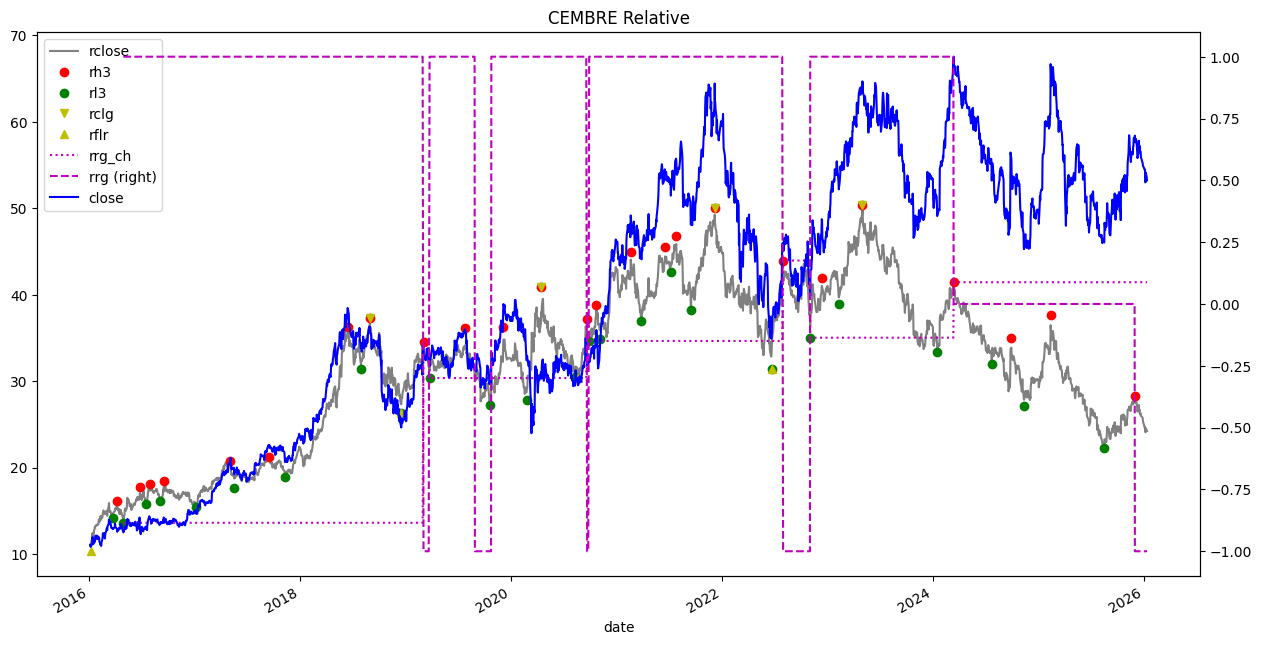

In [97]:
import matplotlib.pyplot as plt

def plot_signal_rel(df, ticker):
    
    plot_rel_cols = ['rclose','rh3', 'rl3','rclg','rflr','rrg_ch','rrg', 'close']
    plot_rel_style = ['grey', 'ro', 'go', 'yv', 'y^','m:','m--', 'b']
    y2_rel = ['rrg']

    # df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')

    df[plot_rel_cols].plot(secondary_y=y2_rel,figsize=(15,8),
            title = str.upper(ticker)+ ' Relative',# grid=True,
            style=plot_rel_style)
    plt.show() 

plot_signal_rel(df, 'cembre')


In [98]:
# top= grid_search.df
top = searcher.df
top

,date,open,high,low,close,fx,ropen,rhigh,rlow,rclose,...,entry_rema_70150200__exit_rsma_50100150,entry_rema_70150200__exit_rsma_70150,entry_rema_70150200__exit_rsma_150200,entry_rema_70150200__exit_rsma_70150200,entry_rema_70150200__exit_rema_50100,entry_rema_70150200__exit_rema_100150,entry_rema_70150200__exit_rema_50100150,entry_rema_70150200__exit_rema_70150,entry_rema_70150200__exit_rema_150200,entry_rema_70150200__exit_rema_70150200
0,2016-01-04,11.405756,11.405756,10.836358,11.076572,1,11.4058,11.4058,10.8364,11.0766,...,0,0,0,0,0,0,0,0,0,0
1,2016-01-05,11.210025,11.245612,10.809666,10.969810,1,11.0770,11.1122,10.6814,10.8396,...,0,0,0,0,0,0,0,0,0,0
2,2016-01-06,10.987605,11.014295,10.720700,10.845255,1,11.1555,11.1826,10.8845,11.0109,...,0,0,0,0,0,0,0,0,0,0
3,2016-01-07,10.569453,11.076573,10.053436,10.898636,1,10.8548,11.3756,10.3248,11.1928,...,0,0,0,0,0,0,0,0,0,0
4,2016-01-08,10.952017,11.094366,10.774079,10.987604,1,11.4288,11.5774,11.2431,11.4660,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2543,2026-01-07,54.500000,54.520000,51.919998,53.000000,1,24.8031,24.8122,23.6289,24.1204,...,0,0,0,0,0,0,0,0,0,0
2544,2026-01-08,52.700001,53.220001,52.419998,53.080002,1,23.9245,24.1606,23.7974,24.0971,...,0,0,0,0,0,0,0,0,0,0
2545,2026-01-09,52.779999,54.279999,52.439999,54.119999,1,23.9362,24.6165,23.7820,24.5439,...,0,0,0,0,0,0,0,0,0,0
2546,2026-01-12,54.419998,54.419998,52.860001,53.599998,1,24.6730,24.6730,23.9657,24.3012,...,0,0,0,0,0,0,0,0,0,0


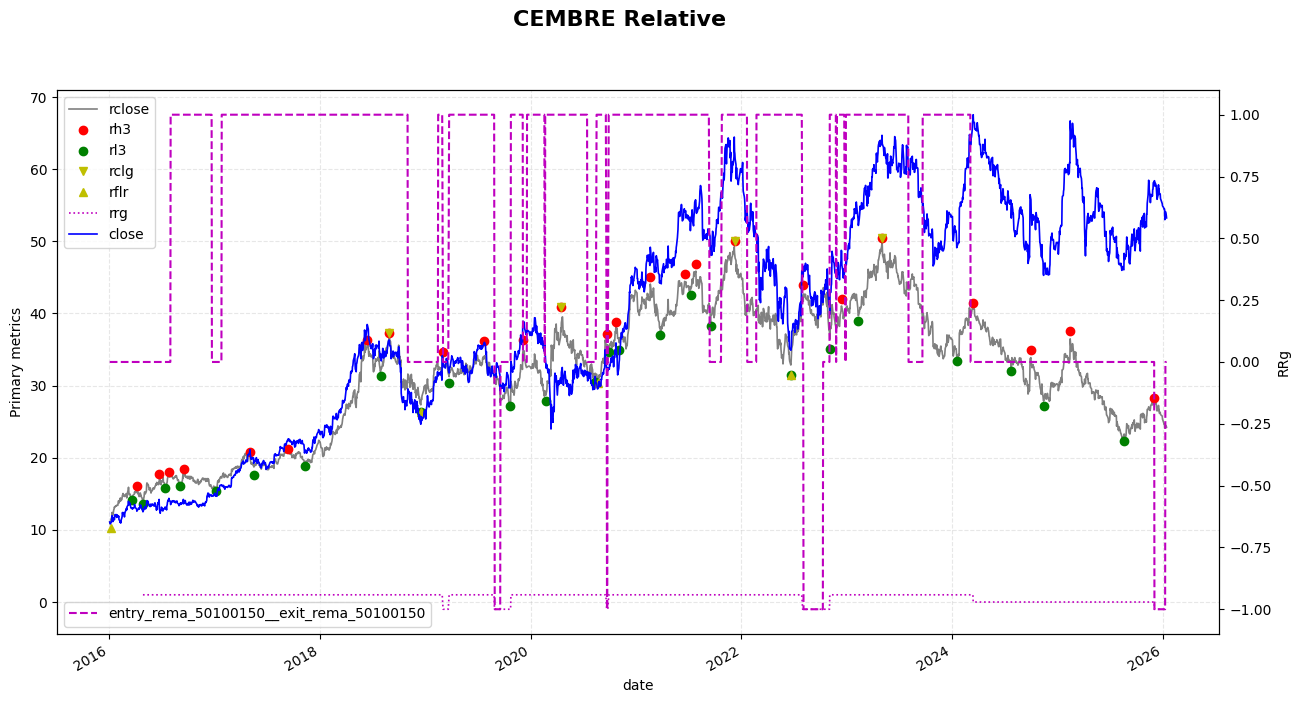

In [100]:
import matplotlib.pyplot as plt

def plot_signal_rel(df, ticker):

    plot_rel_cols = ['rclose','rh3','rl3','rclg','rflr','rrg', 'entry_rema_50100150__exit_rema_50100150', 'close']
    plot_rel_style = ['grey', 'ro', 'go', 'yv', 'y^', 'm:', 'm--', 'b']
    y2_rel = ['entry_rema_50100150__exit_rema_50100150']

    df = df.set_index('date')

    fig, ax1 = plt.subplots(figsize=(15, 8))

    # Primary axis
    df[plot_rel_cols].drop(columns=y2_rel).plot(
        ax=ax1,
        style=[s for c, s in zip(plot_rel_cols, plot_rel_style) if c not in y2_rel],
        linewidth=1.2
    )

    ax1.set_ylabel("Primary metrics")
    ax1.grid(True, linestyle="--", alpha=0.3)

    # Secondary axis
    ax2 = ax1.twinx()
    df[y2_rel].plot(
        ax=ax2,
        style=[plot_rel_style[plot_rel_cols.index(col)] for col in y2_rel],
        linewidth=1.5
    )
    ax2.set_ylabel("RRg")

    # Title
    fig.suptitle(f"{ticker.upper()} Relative", fontsize=16, fontweight="bold")

    plt.show()

plot_signal_rel(top, 'cembre')

In [51]:
top[['date', 'rrg', 'rsma_70150', 'rsma_100150', 'entry_rsma_70150__exit_rsma_100150']]

,date,rrg,rsma_70150,rsma_100150,entry_rsma_70150__exit_rsma_100150
0,2016-01-04,NaN,NaN,NaN,0
1,2016-01-05,NaN,NaN,NaN,0
2,2016-01-06,NaN,NaN,NaN,0
3,2016-01-07,NaN,NaN,NaN,0
4,2016-01-08,NaN,NaN,NaN,0
...,...,...,...,...,...
2557,2026-01-27,-1.0,1.0,1.0,0
2558,2026-01-28,-1.0,1.0,1.0,0
2559,2026-01-29,-1.0,1.0,1.0,0
2560,2026-01-30,-1.0,1.0,1.0,0


In [3]:
optimizer = StrategyOptimizer(
    data=df,
    equity_func=get_equity,
    config_path='config.json'   # ← pass path here
)

results = optimizer.rolling_walk_forward(
    # signals='rrg',
    stop_method='atr',
    param_grid={'window': [10, 14], 'multiplier': [1.5, 2.0]},
    n_segments=4,
    opt_metric='rrg_convex'
)

2026-01-30 16:46:25,900 - algoshort.regime_fc.RegimeFC - WARNING - No peaks found, breaking loop
2026-01-30 16:46:25,900 - WARNING - No peaks found, breaking loop



=== Processing segment 0 |  stop_method='atr' ===
Input columns: ['date', 'open', 'high', 'low', 'close', 'fx', 'ropen', 'rhigh', 'rlow', 'rclose']
Rows: 509
Stop-loss kwargs: {'window': 10, 'multiplier': 1.5}
→ Computing signal 'rrg'...
→ Computing returns...
→ Computing stop-loss using method 'atr'...
→ Computing equity curves...


2026-01-30 16:46:26,720 - algoshort.regime_fc.RegimeFC - WARNING - No peaks found, breaking loop
2026-01-30 16:46:26,720 - WARNING - No peaks found, breaking loop


Saved full segment output: segment_0_rrg_atr_output.xlsx
Segment 0 final equity (atr):
  rrg_constant: 65,147.91
  rrg_concave : 84,230.38
  rrg_convex  : 81,507.82
  rrg_equal_weight: 110,762.32
  segment_idx : 0.00
  signal      : rrg
  stop_method : atr
  rows_processed: 509.00

=== Processing segment 0 |  stop_method='atr' ===
Input columns: ['date', 'open', 'high', 'low', 'close', 'fx', 'ropen', 'rhigh', 'rlow', 'rclose']
Rows: 509
Stop-loss kwargs: {'window': 10, 'multiplier': 2.0}
→ Computing signal 'rrg'...
→ Computing returns...
→ Computing stop-loss using method 'atr'...
→ Computing equity curves...


2026-01-30 16:46:27,408 - algoshort.regime_fc.RegimeFC - WARNING - No peaks found, breaking loop
2026-01-30 16:46:27,408 - WARNING - No peaks found, breaking loop


Saved full segment output: segment_0_rrg_atr_output.xlsx
Segment 0 final equity (atr):
  rrg_constant: 74,225.10
  rrg_concave : 88,027.70
  rrg_convex  : 86,047.42
  rrg_equal_weight: 110,762.32
  segment_idx : 0.00
  signal      : rrg
  stop_method : atr
  rows_processed: 509.00

=== Processing segment 0 |  stop_method='atr' ===
Input columns: ['date', 'open', 'high', 'low', 'close', 'fx', 'ropen', 'rhigh', 'rlow', 'rclose']
Rows: 509
Stop-loss kwargs: {'window': 14, 'multiplier': 1.5}
→ Computing signal 'rrg'...
→ Computing returns...
→ Computing stop-loss using method 'atr'...
→ Computing equity curves...


2026-01-30 16:46:28,164 - algoshort.regime_fc.RegimeFC - WARNING - No peaks found, breaking loop
2026-01-30 16:46:28,164 - WARNING - No peaks found, breaking loop


Saved full segment output: segment_0_rrg_atr_output.xlsx
Segment 0 final equity (atr):
  rrg_constant: 60,781.37
  rrg_concave : 83,395.58
  rrg_convex  : 80,909.96
  rrg_equal_weight: 110,762.32
  segment_idx : 0.00
  signal      : rrg
  stop_method : atr
  rows_processed: 509.00

=== Processing segment 0 |  stop_method='atr' ===
Input columns: ['date', 'open', 'high', 'low', 'close', 'fx', 'ropen', 'rhigh', 'rlow', 'rclose']
Rows: 509
Stop-loss kwargs: {'window': 14, 'multiplier': 2.0}
→ Computing signal 'rrg'...
→ Computing returns...
→ Computing stop-loss using method 'atr'...
→ Computing equity curves...
Saved full segment output: segment_0_rrg_atr_output.xlsx
Segment 0 final equity (atr):
  rrg_constant: 71,055.88
  rrg_concave : 87,440.62
  rrg_convex  : 85,551.38
  rrg_equal_weight: 110,762.32
  segment_idx : 0.00
  signal      : rrg
  stop_method : atr
  rows_processed: 509.00

=== IS results for segment 0 ===
qui

=== Processing segment 0 |  stop_method='atr' ===
Input column

In [4]:
results[0]

,date,rrg_constant,rrg_concave,rrg_convex,rrg_equal_weight,segment_idx,start_date,end_date,signal,stop_method,stop_kwargs,rows_processed,close_col,window,multiplier,segment
0,2020-01-07,102625.60,103283.28,102894.10,96154.03,0,2017-12-29,2020-01-07,rrg,atr,"{'close_col': 'close', 'window': 10, 'multipli...",509,close,10,2.0,1
1,2022-01-04,87972.11,48229.90,93068.67,109397.24,1,2020-01-08,2022-01-04,rrg,atr,"{'close_col': 'close', 'window': 14, 'multipli...",509,close,14,1.5,2
2,2024-01-02,78726.60,60049.70,84283.70,101914.60,2,2022-01-05,2024-01-02,rrg,atr,"{'close_col': 'close', 'window': 10, 'multipli...",509,close,10,1.5,3
3,2026-01-08,58994.11,16790.39,89031.37,106340.73,3,2024-01-03,2026-01-08,rrg,atr,"{'close_col': 'close', 'window': 10, 'multipli...",509,close,10,2.0,4


In [5]:
# from algoshort.regime_bo import RegimeBO
# from algoshort.regime_ma import TripleMACrossoverRegime
# from algoshort.regime_fc import RegimeFC
# from algoshort.regime_bo import RegimeBO
# from algoshort.utils import load_config, extract_signal_name

# def multiple_fc_signals(
#         config_path: str,
#         df: pd.DataFrame,
#         relative: bool = True
#         ):
    
#     # regime_fc = RegimeFC(df=df)
#     # print(*search_space.values())
#     # for lvl_val, vlty_n_val, threshold_val, d_vol_val, dist_pct_val, retrace_pct_val, r_vol_val in zip(*search_space.values()):
#     #     # print(f"Index Match -> short: {w_val}, long: {m_val}")
#     #     df = regime_fc.compute_regime(
#     #         relative = relative,
#     #         lvl = lvl_val,
#     #         vlty_n = vlty_n_val,
#     #         threshold = threshold_val,
#     #         dgt = 3,
#     #         d_vol = d_vol_val,
#     #         dist_pct = dist_pct_val,
#     #         retrace_pct = retrace_pct_val,
#     #         r_vol = r_vol_val
#     #     )
#     config = load_config(config_path)

#     regime_fc = RegimeFC(df=df)
#     df = regime_fc.compute_regime(
#         relative = relative,
#         lvl = config['regimes']['floor_ceiling']['lvl'],
#         vlty_n = config['regimes']['floor_ceiling']['vlty_n'],
#         threshold = config['regimes']['floor_ceiling']['threshold'],
#         dgt = config['regimes']['floor_ceiling']['dgt'],
#         d_vol = config['regimes']['floor_ceiling']['d_vol'],
#         dist_pct = config['regimes']['floor_ceiling']['dist_pct'],
#         retrace_pct = config['regimes']['floor_ceiling']['retrace_pct'],
#         r_vol = config['regimes']['floor_ceiling']['r_vol']
#     )
        
#     return df

# def multiple_tt_signals(
#         search_space : dict,
#         df: pd.DataFrame,
#         relative: bool = True
#         ):
    
#     regime_bo = RegimeBO(ohlc_stock=df)

#     for w_val, m_val in zip(*search_space.values()):
#         print(f"Index Match -> short: {w_val}, long: {m_val}")
#         df = regime_bo.compute_regime(regime_type='turtle', fast_window=w_val,
#                                 window=m_val,
#                                 relative=relative, inplace=True)
        
#     return df

# def multiple_bo_signals(
#         search_space,
#         df: pd.DataFrame,
#         relative: bool = True
#         ):
    
#     regime_bo = RegimeBO(ohlc_stock=df)

#     for w_val in search_space:
#         print(f"Index Match -> Window: {w_val}")
#         df = regime_bo.compute_regime(regime_type='breakout', window=w_val,
#                              relative=relative, inplace=True)
        
#     return df

# def multiple_ma_signals(
#         search_space,
#         df: pd.DataFrame,
#         relative: bool = True
#         ):
    
#     regime_ma = TripleMACrossoverRegime(ohlc_stock=df)

#     for ma_type in ['sma', 'ema']:
#         for s_val, m_val, l_val in zip(*search_space.values()):
#             print(f"Index Match -> short: {s_val}, medium: {m_val}, long: {l_val}")
#             regime_ma.compute_ma_regime(
#                 ma_type=ma_type,
#                 short_window=s_val,
#                 medium_window=m_val,
#                 long_window=l_val,
#                 relative=relative,
#                 inplace=True
#             )    
        
#     return df

# def generate_signals(
#         df: pd.DataFrame, 
#         tt_search_space: dict,
#         bo_search_space: dict,
#         ma_search_space:dict,
#         # fc_search_space:dict,
#         config_path='./config.json',
#         relative: bool = True,
#         ) -> tuple[pd.DataFrame, list]:
#     """
#     Generates signals for breakout, Turtle Trader, and MA crossover regimes.
    
#     Args:
#         df: DataFrame with OHLC data (e.g., AAPL_Open, SPY_Close).
#         symbol: Ticker symbol (e.g., 'AAPL').
#         benchmark: Benchmark ticker (e.g., 'SPY').
#         config_path: Path to JSON config file.
    
#     Returns:
#         tuple: (DataFrame with signal columns, list of signal column names).
    
#     Raises:
#         ValueError: If input DataFrame is missing required columns or config is invalid.
#     """
#     # regime_bo = RegimeBO(ohlc_stock=df)
#     # regime_ma = TripleMACrossoverRegime(ohlc_stock=df)

#     # config = load_config(config_path)

#     df = multiple_bo_signals(search_space=bo_search_space, df=df, relative=relative)
    
#     df = multiple_tt_signals(search_space=tt_search_space, df=df, relative=relative)

#     df = multiple_ma_signals(search_space=ma_search_space,df=df,relative=relative)

#     df = multiple_fc_signals(config_path,df,relative)
    
#     # Get signal column names
#     signal_names = extract_signal_name(config_path)
    
#     # Verify signal columns exist
#     missing_signals = [name for name in signal_names if name not in df.columns]
#     if missing_signals:
#         warnings.warn(f"Signal columns not generated: {missing_signals}", UserWarning)
    
#     # Select signal columns dynamically
#     signal_columns = [col for col in df.columns if any(col.startswith(prefix) for prefix in ['rbo_', 'bo_', 'rtt_', 'tt_', 'rsma_', 'sma_', 'rema_', 'ema_', 'rg', 'rrg'])]
    
#     signal_columns = [
#         item for item in signal_columns
#         if not any(keyword in item for keyword in ['short', 'medium', 'long'])
#     ]

#     return df, signal_columns

In [6]:
# tt_search_space = {
#     'fast': [10, 20, 30],
#     'slow': [50, 50, 70]
# }

# bo_search_space = [50, 100, 150]

# ma_search_space = {
#     'short_ma': [20, 50, 70],
#     'medium_ma': [50, 100, 150],
#     'long_ma': [100, 150, 200]
# }


# df, signal_columns = generate_signals(
#     df=df,
#     tt_search_space=tt_search_space,
#     bo_search_space=bo_search_space,
#     ma_search_space=ma_search_space,
# )
# df.columns

In [7]:
# from algoshort.optimizer import get_equity

# df = get_equity(
#     segment_df=df,
#     signal='rrg',
#     segment_idx=0,
#     config_path='config.json',
#     param_grid={'window': [10], 'multiplier': [1.5]}
# )

In [8]:
# df.columns

In [9]:
# sl_signal_columns = [col for col in df.columns if any(col.endswith(prefix) for prefix in ['stop_loss'])]
# sl_signal_columns

In [10]:
# df.to_excel('check.xlsx')